In [1]:
import os
os.environ["PKG_CONFIG_PATH"] = "/home/jaeyonglee/anaconda3/envs/fenics/lib/pkgconfig"

In [2]:
import numpy as np
import scipy
from scipy import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import torch

In [3]:
import dolfin
from dolfin import *
from mshr import *

### 2D Poisson equation on square with a circle hole

#### Learning the solution operator $\mathcal{G}:c(x)\mapsto u(x)$ for
##### $-\Delta u(x,y)=f(x,y)$, $(x,y)\in D$,
##### $u(x,y)=0$, $(x,y)\in\partial D$.

Setting num :15 // Num Element : 555


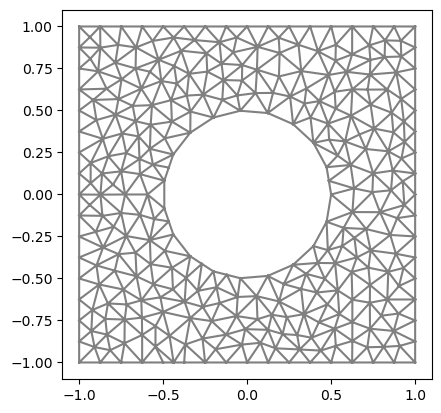

In [4]:
num=15
domain = Rectangle(Point(-1,-1), Point(1,1))-Circle(Point(0,0), 0.5)
mesh = generate_mesh(domain, num)
plot(mesh)
print("Setting num :{} // Num Element : {}".format(num, mesh.cells().shape[0]))

In [5]:
# Preconditioning
from scipy.sparse import identity
from scipy.sparse import diags
from scipy.sparse.linalg import onenormest

def spai(A, m):
    """Perform m step of the SPAI iteration."""

    n = A.shape[0]

    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A

    for index in tqdm(range(m)):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G

    return M

In [6]:
def fenics_mesh(num_xy, num_input, deg_v, save_precond, deg_f=5):
  domain = Rectangle(Point(-1,-1), Point(1,1))-Circle(Point(0,0), 0.5)
  mesh = generate_mesh(domain, num_xy)
  V = FunctionSpace(mesh, "Lagrange", deg_v)

  u_D = Constant(0.0)
  def boundary(x, on_boundary):
      return on_boundary
  bc = DirichletBC(V, u_D, boundary)

  u = TrialFunction(V)
  v = TestFunction(V)

  a = dot(grad(u), grad(v))*dx
  A = PETScMatrix()
  A = assemble(a)
  bc.apply(A)
  stiff = A.array()
  if save_precond:
    precond = spai(stiff, 20)
    print(np.linalg.cond(stiff))
    print(np.linalg.cond(stiff@precond))
  else:
    precond = torch.zeros(stiff.shape)

 

  train_coeff_fs=[]
  train_load_vectors=[]
  np.random.seed(5)
  for i in range(num_input[0]):
    m0, m1 = 1 + np.random.rand(2)
    n0, n1, n2, n3 = np.pi*(np.random.rand(4))
    f =Expression('m0*sin(n0*x[0]+n1*x[1]) + m1*cos(n2*x[0]+n3*x[1])', degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1,n2=n2,n3=n3)
    bc = DirichletBC(V, u_D, boundary)
    l = f*v*dx
    L = assemble(l)
    bc.apply(L)
    load_vector = L.get_local()
    train_coeff_fs.append(np.array([m0, m1, n0, n1, n2, n3]))
    train_load_vectors.append(load_vector)

  validate_coeff_fs=[]
  validate_load_vectors=[]
  np.random.seed(10)
  for i in range(num_input[1]):
    m0, m1 = 1 + np.random.rand(2)
    n0, n1, n2, n3 = np.pi*(np.random.rand(4))
    f =Expression('m0*sin(n0*x[0]+n1*x[1]) + m1*cos(n2*x[0]+n3*x[1])', degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1,n2=n2,n3=n3)
    bc = DirichletBC(V, u_D, boundary)
    l = f*v*dx
    L = assemble(l)
    bc.apply(L)
    load_vector = L.get_local()
    validate_coeff_fs.append(np.array([m0, m1, n0, n1, n2, n3]))
    validate_load_vectors.append(load_vector)

  ne=mesh.cells().shape[0]
  dofmap = V.dofmap()
  p = V.tabulate_dof_coordinates()
  ng = p.shape[0]

  c=[]
  for i in range(ne):
    c.append(dofmap.cell_dofs(i))
  c=np.asarray(c)

  idx_bdry_pts=list(bc.get_boundary_values().keys())
  idx_bdry_pts

  gfl = np.zeros((ng))
  gfl[idx_bdry_pts]=1

  print("Num of Elements : {}, Num of points : {}".format(ne, ng))
  return ne, ng, p, c, gfl, stiff, precond, np.array(train_coeff_fs), np.array(train_load_vectors), np.array(validate_coeff_fs), np.array(validate_load_vectors)


In [7]:
order=2
list_num_xy=[15,25]
num_input=[1000, 1000]
save_precond=[True,False]
typ='circlehole'

In [8]:
list_ne=[]
for idx, num in enumerate(list_num_xy):
  ne, ng, p, c, gfl, stiff, precond, train_coeff_fs, train_load_vectors, validate_coeff_fs, validate_load_vectors=fenics_mesh(num, num_input, order, save_precond[idx])
  np.savez('mesh/P{}_ne{}_{}.npz'.format(order,ne,typ),ne=ne,ng=ng,p=p,c=c,gfl=gfl,stiff=stiff,precond=precond,train_coeff_fs=train_coeff_fs, train_load_vectors=train_load_vectors, validate_coeff_fs=validate_coeff_fs, validate_load_vectors=validate_load_vectors)
  list_ne.append(ne)
print(list_ne)

100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


145.65151098528108
5.5916860434390845
Num of Elements : 555, Num of points : 1199
Num of Elements : 1530, Num of points : 3232
[555, 1530]


In [9]:
def fenics_data(num_xy, num_input, deg_v, deg_f=5):
  # Set solver parameters to suppress output
  parameters["std_out_all_processes"] = False  # Suppress output for parallel runs
  set_log_level(LogLevel.ERROR)  # Suppress solver logs
  
  domain = Rectangle(Point(-1,-1), Point(1,1))-Circle(Point(0,0), 0.5)
  mesh = generate_mesh(domain, num_xy)
  V = FunctionSpace(mesh, "Lagrange", deg_v)

  u_D = Constant(0.0)
  def boundary(x, on_boundary):
      return on_boundary
  bc = DirichletBC(V, u_D, boundary)

  u = TrialFunction(V)
  v = TestFunction(V)

  train_fenics_u=[]
  np.random.seed(5)
  for i in range(num_input[0]):
    u = TrialFunction(V)
    v = TestFunction(V)
    
    a = dot(grad(u), grad(v))*dx

    m0, m1 = 1 + np.random.rand(2)
    n0, n1, n2, n3 = np.pi*(np.random.rand(4))
    f =Expression('m0*sin(n0*x[0]+n1*x[1]) + m1*cos(n2*x[0]+n3*x[1])', degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1,n2=n2,n3=n3)
    l = f*v*dx

    u = Function(V)
    solve(a == l, u, bc)
    fenics_u = u.vector().get_local()

    p = V.tabulate_dof_coordinates()
    train_fenics_u.append([fenics_u, m0*np.sin(n0*p[:,0]+n1*p[:,1]) + m1*np.cos(n2*p[:,0]+n3*p[:,1]), np.array([m0, m1, n0, n1, n2, n3])])

  validate_fenics_u=[]
  np.random.seed(10)
  for i in range(num_input[1]):
    u = TrialFunction(V)
    v = TestFunction(V)
    
    a = dot(grad(u), grad(v))*dx

    m0, m1 = 1 + np.random.rand(2)
    n0, n1, n2, n3 = np.pi*(np.random.rand(4))
    f =Expression('m0*sin(n0*x[0]+n1*x[1]) + m1*cos(n2*x[0]+n3*x[1])', degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1,n2=n2,n3=n3)
    l = f*v*dx

    u = Function(V)
    solve(a == l, u, bc)
    fenics_u = u.vector().get_local()

    p = V.tabulate_dof_coordinates()
    validate_fenics_u.append([fenics_u, m0*np.sin(n0*p[:,0]+n1*p[:,1]) + m1*np.cos(n2*p[:,0]+n3*p[:,1]), np.array([m0, m1, n0, n1, n2, n3])])

  return np.array(train_fenics_u, dtype=object), np.array(validate_fenics_u, dtype=object), mesh.cells().shape[0]


In [10]:
order=2
list_num_xy=[25]
num_input=[1000, 1000]
typ='circlehole'

In [11]:
import pickle
for idx, num in enumerate(list_num_xy):
      train_fenics_u,validate_fenics_u, ne = fenics_data(num, num_input, deg_v=order)
      with open('data/train_P{}_{}N{}_{}.pkl'.format(order,num_input[0],ne,typ), 'wb') as f:
            pickle.dump(train_fenics_u, f, pickle.HIGHEST_PROTOCOL)
      with open('data/validate_P{}_{}N{}_{}.pkl'.format(order,num_input[1],ne,typ), 'wb') as f:
            pickle.dump(validate_fenics_u, f, pickle.HIGHEST_PROTOCOL)